In [1]:
!pip install pesq jiwer datasets -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.3.3 requires dill>=0.3.9, but you have dill 0.3.8 which is incompatible.
pathos 0.3.3 requires multiprocess>=0.70.17, but you have multiprocess 0.70.16 which is incompatible.


In [2]:
!pip install "deeplake<4" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.3.9 which is incompatible.


In [3]:
!pip install git+https://github.com/huggingface/parler-tts.git -q

In [26]:
!pip install --upgrade protobuf

  Using cached protobuf-5.28.2-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
descript-audiotools 0.7.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 5.28.2 which is incompatible.
opentelemetry-proto 1.27.0 requires protobuf<5.0,>=3.19, but you have protobuf 5.28.2 which is incompatible.
tensorflow-intel 2.17.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.28.2 which is incompatible.


In [2]:
import librosa
import numpy as np
from pesq import pesq
from jiwer import wer

from tqdm import tqdm

import torch
from parler_tts import ParlerTTSForConditionalGeneration, ParlerTTSConfig
from transformers import AutoTokenizer
import soundfile as sf

from datasets import load_dataset
from transformers import WhisperProcessor, WhisperForConditionalGeneration

c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Flash attention 2 is not installed


In [14]:
sampling_rate = 16000

device = "cuda:0" if torch.cuda.is_available() else "cpu"

c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [90]:
parlerTTSModel = ParlerTTSForConditionalGeneration.from_pretrained("parler-tts/parler-tts-mini-jenny-30H").to(device)
parlerTTSTokenizer = AutoTokenizer.from_pretrained("parler-tts/parler-tts-mini-jenny-30H")

c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [75]:
def make_synt(
    prompt,
    description="Jenny speaks at an average pace with an animated delivery in a very confined sounding environment with clear audio quality."
  ):

  input_ids = parlerTTSTokenizer(description, return_tensors="pt").input_ids.to(device)
  prompt_input_ids = parlerTTSTokenizer(prompt, return_tensors="pt").input_ids.to(device)

  generation = np.array([[]])
  while generation.shape[1] <= 2:
    generation = parlerTTSModel.generate(input_ids=input_ids, prompt_input_ids=prompt_input_ids)
    if generation.shape[1] <= 2:
      print("Retrying to generate")

  audio_arr = generation.cpu().numpy().squeeze()

  return audio_arr

Изначальный план был построен на оценке с помощью двух датасетов дикторской озвучки коротки и длинных / сложных и простых текстов, но второй датасет не скачивался =(

In [23]:
# import deeplake

lj_speech_dataset = load_dataset("keithito/lj_speech", trust_remote_code=True)
# vctk_dataset = load_dataset("CSTR-Edinburgh/vctk", trust_remote_code=True)

In [28]:
whisperProcessor = WhisperProcessor.from_pretrained("openai/whisper-base")
whisperModel = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base").to(device)

In [40]:
def get_sub(audio):
  input_features = whisperProcessor(audio, return_tensors="pt", sampling_rate=sampling_rate).input_features

  generated_ids = whisperModel.generate(input_features.cuda())
  transcription = whisperProcessor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  return transcription

Будем использовать три объективных метрики для анализа:
1. MCD - частотный анализ разницы между синтезом и оригиналом. Данная метрика, вероятно, покажет не сильно хорошие значения в виду различия пола дикторов и их тембра голоса.
1. PESQ - автометрика качества речи, основанная на восприятия речи человеческим слухом.
1. WER - процент слов, неверно воспроизведенных моделью по сравнению с исходным текстом. Сравнивается с расшифровкой Wisper-а (по сути, автометрика). Wisper очень хорошо работает с чётким голосом, так что отклонения метрики из-за него можно считать незначительными.


PS:
1. `0.0 <= MCD (higher = better)`
1. `-0.5 <= PESQ <= 4.5 (higher = better)`
1. `0.0 <= WER <= 1.0 (lower = better)`

In [65]:
def calc_metrics(ref_audio, ref_text, gen_audio, gen_text):
  ref_mfcc = librosa.feature.mfcc(y=ref_audio, sr=sampling_rate, n_mfcc=13)
  syn_mfcc = librosa.feature.mfcc(y=gen_audio, sr=sampling_rate, n_mfcc=13)
  shrink_size = min(ref_mfcc.shape[1], syn_mfcc.shape[1])
  ref_mfcc = ref_mfcc[:,:shrink_size]
  syn_mfcc = syn_mfcc[:,:shrink_size]
  mcd_score = np.mean(np.sqrt(np.sum((ref_mfcc - syn_mfcc) ** 2, axis=0)))

  pesq_score = pesq(sampling_rate, ref_audio, gen_audio, 'wb')

  wer_score = wer(ref_text, gen_text)

  return mcd_score, pesq_score, wer_score

In [82]:
def dataset_to_metrics(dataset, max_size=100):
  metrics = []

  cnt = len(dataset)
  cnt = min(cnt, max_size)

  for idx in tqdm(range(cnt)):
    ref_audio, ref_text = dataset["audio"][idx]["array"], dataset["text"][idx]

    gen_audio = make_synt(ref_text)

    ref_audio_resampled = librosa.resample(ref_audio, orig_sr=dataset["audio"][idx]["sampling_rate"], target_sr=sampling_rate)
    gen_audio_resampled = librosa.resample(gen_audio, orig_sr=parlerTTSModel.config.sampling_rate, target_sr=sampling_rate)

    gen_text = get_sub(gen_audio_resampled)

    sample_metrics = calc_metrics(ref_audio_resampled, ref_text, gen_audio_resampled, gen_text)
    metrics.append(sample_metrics)

  return np.dstack(metrics)

In [91]:
metrics = dataset_to_metrics(lj_speech_dataset["train"], 100)

  1%|          | 1/100 [00:37<1:02:32, 37.90s/it]

Retring to generate


  5%|▌         | 5/100 [02:34<48:08, 30.40s/it]  

Retring to generate


 14%|█▍        | 14/100 [06:50<42:04, 29.36s/it]

Retring to generate


 19%|█▉        | 19/100 [09:28<39:29, 29.26s/it]

Retring to generate
Retring to generate


 25%|██▌       | 25/100 [12:37<38:20, 30.68s/it]

Retring to generate


 26%|██▌       | 26/100 [13:12<39:27, 31.99s/it]

Retring to generate


 31%|███       | 31/100 [15:49<34:29, 29.99s/it]

Retring to generate


 32%|███▏      | 32/100 [16:25<35:51, 31.63s/it]

Retring to generate


 40%|████      | 40/100 [20:53<29:26, 29.44s/it]

Retring to generate


 49%|████▉     | 49/100 [25:05<24:04, 28.32s/it]

Retring to generate
Retring to generate


 50%|█████     | 50/100 [25:46<26:41, 32.02s/it]

Retring to generate
Retring to generate


 57%|█████▋    | 57/100 [29:05<20:51, 29.11s/it]

Retring to generate


 60%|██████    | 60/100 [30:44<20:37, 30.94s/it]

Retring to generate
Retring to generate
Retring to generate


 62%|██████▏   | 62/100 [31:52<20:11, 31.87s/it]

Retring to generate
Retring to generate
Retring to generate


 73%|███████▎  | 73/100 [37:29<13:05, 29.08s/it]

Retring to generate


 74%|███████▍  | 74/100 [38:05<13:32, 31.27s/it]

Retring to generate


 77%|███████▋  | 77/100 [39:40<11:46, 30.74s/it]

Retring to generate


 89%|████████▉ | 89/100 [45:19<05:26, 29.67s/it]

Retring to generate
Retring to generate


 99%|█████████▉| 99/100 [50:20<00:30, 30.15s/it]

Retring to generate


100%|██████████| 100/100 [51:04<00:00, 30.64s/it]


In [95]:
import pickle

with open("metrics.pickle", "wb") as f:
    pickle.dump(metrics, f)

In [96]:
metrics = metrics[0]

In [112]:
mcd_score_mean, pesq_score_mean, wer_score_mean = metrics.mean(axis=1)
print(f"means: | MCD: {mcd_score_mean} | PESQ: {pesq_score_mean} | WER: {wer_score_mean} |")

MCD: 181.2842762855618, PESQ: 1.1381073236465453, WER: 0.2498852792778004


In [124]:
def dataset_to_files(dataset, max_size=100):
  cnt = len(dataset)
  cnt = min(cnt, max_size)

  for idx in tqdm(range(cnt)):
    ref_text = dataset["text"][idx]

    gen_audio = make_synt(ref_text)
    
    sf.write(f"./output/parler_tts_out_{idx}.wav", gen_audio, parlerTTSModel.config.sampling_rate)

In [127]:
dataset_to_files(lj_speech_dataset["train"], 100)

  3%|▎         | 3/100 [00:26<14:03,  8.69s/it]

Retring to generate


 11%|█         | 11/100 [01:40<12:19,  8.31s/it]

Retring to generate


 12%|█▏        | 12/100 [01:54<14:32,  9.91s/it]

Retring to generate
Retring to generate
Retring to generate
Retring to generate


 13%|█▎        | 13/100 [02:13<18:24, 12.69s/it]

Retring to generate


 16%|█▌        | 16/100 [02:59<17:38, 12.60s/it]

Retring to generate


 23%|██▎       | 23/100 [04:20<14:11, 11.06s/it]

Retring to generate


 24%|██▍       | 24/100 [04:38<16:36, 13.12s/it]

Retring to generate


 28%|██▊       | 28/100 [05:26<12:57, 10.79s/it]

Retring to generate


 31%|███       | 31/100 [05:59<12:10, 10.58s/it]

Retring to generate


 34%|███▍      | 34/100 [06:40<12:54, 11.73s/it]

Retring to generate
Retring to generate
Retring to generate


 36%|███▌      | 36/100 [07:17<15:25, 14.47s/it]

Retring to generate


 42%|████▏     | 42/100 [08:15<09:19,  9.65s/it]

Retring to generate
Retring to generate


 49%|████▉     | 49/100 [09:12<07:04,  8.33s/it]

Retring to generate
Retring to generate
Retring to generate


 52%|█████▏    | 52/100 [11:22<19:02, 23.80s/it]

Retring to generate
Retring to generate
Retring to generate


 53%|█████▎    | 53/100 [11:47<18:52, 24.09s/it]

Retring to generate
Retring to generate


 55%|█████▌    | 55/100 [12:13<13:41, 18.26s/it]

Retring to generate
Retring to generate


 57%|█████▋    | 57/100 [12:46<12:02, 16.80s/it]

Retring to generate


 60%|██████    | 60/100 [13:26<09:15, 13.88s/it]

Retring to generate
Retring to generate


 62%|██████▏   | 62/100 [13:50<07:50, 12.39s/it]

Retring to generate


 71%|███████   | 71/100 [15:21<04:47,  9.92s/it]

Retring to generate


 79%|███████▉  | 79/100 [16:41<02:45,  7.87s/it]

Retring to generate


 85%|████████▌ | 85/100 [17:34<02:10,  8.72s/it]

Retring to generate


 89%|████████▉ | 89/100 [18:18<01:50, 10.07s/it]

Retring to generate
Retring to generate


 95%|█████████▌| 95/100 [19:12<00:38,  7.80s/it]

Retring to generate


100%|██████████| 100/100 [20:20<00:00, 12.21s/it]


И одна доп. метрика субъективного оценивания восприятия "машинности" перевода: MOC

`0 <= MOC <= 5 (higher = better)`

In [3]:
moc_score = [
#   0  1  2  3  4  5  6  7  8  9
    3, 5, 4, 5, 4, 4, 3, 5, 5, 3, # 0
    4, 5, 4, 4, 4, 5, 3, 5, 4, 5, # 1
    4, 4, 5, 4, 5, 4, 5, 5, 5, 3, # 2
    4, 5, 5, 4, 5, 4, 4, 2, 5, 4, # 3
    # 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, # 4
    # 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, # 5
    # 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, # 6
    # 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, # 7
    # 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, # 8
    # 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, # 9
]

moc_score = np.array(moc_score)

In [5]:
moc_score_mean = moc_score.mean()
print(f"MOC mean: {moc_score_mean}")

MOC mean: 4.25


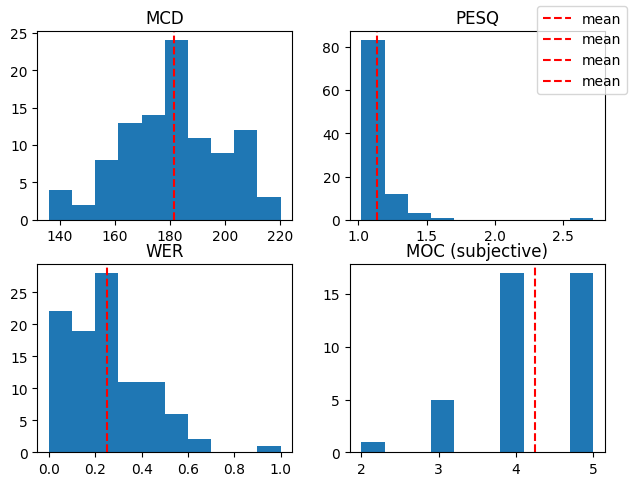

In [163]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.tight_layout()
ax1.hist(metrics[0], bins=10)
ax2.hist(metrics[1], bins=10)
ax3.hist(metrics[2], bins=10)
ax4.hist(moc_score)
ax1.set_title("MCD")
ax2.set_title("PESQ")
ax3.set_title("WER")
ax4.set_title("MOC (subjective)")
ax1.axvline(x=mcd_score_mean, color='red', linestyle='--', label='mean')
ax2.axvline(x=pesq_score_mean, color='red', linestyle='--', label='mean')
ax3.axvline(x=wer_score_mean, color='red', linestyle='--', label='mean')
ax4.axvline(x=moc_score_mean, color='red', linestyle='--', label='mean')
fig.legend()
fig.savefig("output.png", dpi=300, pad_inches=0.1, bbox_inches='tight')